In [1]:
import numpy as np
import matplotlib.pyplot as plt
import compute_parameters
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm
from scipy.optimize import curve_fit
import pylab

In [2]:
def get_actual_predicted(trace, trace_name, jvm, hidden_size, history_size=40, seed=0,
                        output_file_location="/media/arjun/Shared/chaos/output_files"):
    start_point = 10000
    n_points = 5000
    
    if jvm == "jikes":
        jvm_name = "JikesRVM"
    elif jvm == "j9":
        jvm_name = "J9"
    else:
        jvm_name = "HotSpot"
    
    offset = 3
    
    data = []
    
    predictions = np.load(
                    '{}/{}/{}/predictions_{}_{}_{}_{}.npy'.format(output_file_location, 
                                                                  trace_name, jvm, history_size, 
                                                                  seed, hidden_size, 1))
    predictions = np.argsort(predictions)
#     print(predictions.shape)
#     print(trace.shape)
    for idx, point in enumerate(trace):
        if idx >= len(trace)-offset-1:
            continue
#         print("{}: {}".format(np.argmax(point), predictions[history_size-1+idx, -1]))
        actual = bin_to_val(int(np.argmax(point)))
        predicted = bin_to_val(predictions[history_size+idx+offset, -1])
    
        data.append((actual, predicted))
    
    return data

In [3]:
def mse_function(y, y1):
    return np.mean((y-y1)**2)

## precision and recall
def relevance_function1(x, sigma=1.0, mu=0):
    return np.exp(-((x-mu)**2)/(2*(sigma**2)))/(sigma*np.sqrt(2*np.pi))


def relevance_function(x, mu=0):
    return 1


def alpha(y, y_pred, loss_function=mse_function, threshold=5e-1):
    return loss_function(y, y_pred) < threshold


def recall(data, y_ref, loss_function=mse_function, relevance_threshold=0.3, alpha_threshold=5e-1):
    num = 0
    din = 0
    for y_actual, y_pred in data:
        phi_y = relevance_function(y_actual, mu=y_ref)
        if phi_y >= relevance_threshold:
            num += alpha(y_actual, y_pred, loss_function, alpha_threshold) * phi_y
            din += phi_y
    
    if din > 0:
        return num/din
    else:
        return 0

    

def existance_check(data, y_ref, loss_function=mse_function, relevance_threshold=0.3):
    num = 0
    din = 0
    exists = False
    for y_actual, y_pred in data:
        phi_y = relevance_function(y_actual, mu=y_ref)
        if phi_y >= relevance_threshold:
            return True
    
    return False


def precision(data, y_ref, loss_function=mse_function, relevance_threshold=0.3, alpha_threshold=5e-1):
    num = 0
    din = 0
    for y_actual, y_pred in data:
        phi_y1 = relevance_function(y_pred, mu=y_ref)
        if phi_y1 >= relevance_threshold:
            num += alpha(y_actual, y_pred, loss_function, alpha_threshold) * phi_y1
            din += phi_y1
    
    if din > 0:
        return num/din
    else:
        return 0
    
    
def f1_score(precision, recall, beta=1):
    if precision+recall > 0:
        return ((1+beta**2)*precision*recall)/(precision+recall)
    else:
        return 0
    

def bin_to_val(bin_idx):
    g_max = 1
    g_min = 3 * np.exp(-8)
    feature_dimension = 100
    multiplier = (np.log(g_max) - np.log(g_min))/feature_dimension # values from preprocess cache file
    
    return bin_idx*multiplier + np.log(g_min)

In [4]:
def sup(arr, mode="999percentile"):
    if mode == "max":
        return (np.max(arr))
    elif mode == "999percentile":
        return np.mean(arr) + 5 * np.std(arr)


def get_rademacher(loss_array):
    rademacher = []
    
    n_sigma = 2000
    
    for i in range(n_sigma):
        sigma_arr = np.random.choice([1, -1], size=loss_array.shape)

        f = sigma_arr*loss_array
        f = np.sum(f, axis=1)/loss_array.shape[1]
        # print(f)
        rademacher.append(sup(f))
    
    return np.mean(rademacher)

In [5]:
## loss dict with random samples and without linspace

def get_loss_dict4(trace, output_file_location, hidden_sizes=None, trace_name="pmd", 
                   plot_graphs=False, alpha_threshold=5e-1):

    if hidden_sizes is None:
        hidden_sizes = [ 10, 50, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000 ]
    
#     history_sizes = [ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50 ]
    history_size = 40
    n_seeds = 30
    n_sets = 50
    n_points = 5000
    chunk_size = 500
    relevance_threshold = relevance_function(4e-1)
    loss_dict = {}
    min_val = np.log(3e-8)
    max_val = 0
    n_steps = 50
    
    rademacher_list = []
    
#     print("relevance threshold: {}".format(relevance_threshold))
    
    for hidden_size in hidden_sizes:
        loss_array = np.zeros((n_seeds, n_sets))
#         print("hidden_size: {}".format(hidden_size))

        if hidden_size in loss_dict.keys():
            continue

        for seed in range(n_seeds):
            data1 = get_actual_predicted(trace, trace_name, "jikes", hidden_size=hidden_size, seed=seed, 
                                         history_size=40, output_file_location=output_file_location)

#             indices = np.arange(0, n_points, chunk_size)
#             indices = np.random.choice(np.arange(0, n_points-chunk_size), n_sets)

            for index_idx in range(n_sets):
                index_list = np.random.choice(np.arange(len(data1)), chunk_size)
                data = [ data1[index] for index in index_list ]
                
                val = 0
                recall_val = recall(data, val, relevance_threshold=relevance_threshold, 
                                    alpha_threshold=alpha_threshold)
                precision_val = precision(data, val, relevance_threshold=relevance_threshold, 
                                          alpha_threshold=alpha_threshold)
                
                f1_val = f1_score(precision_val, recall_val)

                loss_array[seed, index_idx] = 1-f1_val
                
        loss_dict[hidden_size] = loss_array
        rademacher_val = get_rademacher(loss_array)
    
        if len(rademacher_list) > 0:
            min_rademacher = np.min(rademacher_list)
            argmin_rademacher = np.argmin(rademacher_list)
            min_hidden = hidden_sizes[argmin_rademacher]
        
            print("Rademacher: {}, min_rademacher: {}, min_size: {}".format(rademacher_val, 
                                                                        min_rademacher,
                                                                       min_hidden))
            print("percent improvement: {}".format((min_rademacher-rademacher_val)*100/min_rademacher))
    
    
        rademacher_list.append(rademacher_val)
    
    return loss_dict

In [6]:
def get_loss_dict3(trace, output_file_location, hidden_sizes=None, trace_name="pmd", plot_graphs=False):

    if hidden_sizes is None:
        hidden_sizes = [ 10, 50, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000 ]
    
#     history_sizes = [ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50 ]
    history_size = 40
    n_seeds = 30
    n_sets = 1
    n_points = 5000
    chunk_size = int(n_points/n_sets)
    relevance_threshold = relevance_function(1e-1)
    loss_dict = {}
    min_val = np.log(3e-8)
    max_val = 0
    n_steps = 50
    
    rademacher_list = []
    
    print("relevance threshold: {}".format(relevance_threshold))
    
    for hidden_size in hidden_sizes:
        loss_array = np.zeros((n_seeds, n_sets))
        print("hidden_size: {}".format(hidden_size))

        if hidden_size in loss_dict.keys():
            continue

        for seed in range(n_seeds):
            data1 = get_actual_predicted(trace, trace_name, "jikes", hidden_size=hidden_size, seed=seed, 
                                         history_size=40, output_file_location=output_file_location)

            indices = np.arange(0, n_points, chunk_size)

            for index in indices:
                data = data1[index:index+chunk_size]
                
                val = 0
                recall_val = recall(data, val, relevance_threshold=relevance_threshold)
                precision_val = precision(data, val, relevance_threshold=relevance_threshold)
                
                f1_val = f1_score(precision_val, recall_val)

                chunk_idx = int(index/chunk_size)
                loss_array[seed, chunk_idx] = 1-np.average(f1_val)
                
        loss_dict[hidden_size] = loss_array
        rademacher_val = get_rademacher(loss_array)
    
        if len(rademacher_list) > 0:
            min_rademacher = np.min(rademacher_list)
            argmin_rademacher = np.argmin(rademacher_list)
            min_hidden = hidden_sizes[argmin_rademacher]
        
            print("Rademacher: {}, min_rademacher: {}, min_size: {}".format(rademacher_val, 
                                                                        min_rademacher,
                                                                       min_hidden))
            print("percent improvement: {}".format((min_rademacher-rademacher_val)*100/min_rademacher))
    
    
        rademacher_list.append(rademacher_val)
    
    return loss_dict

In [7]:
def get_loss_dict1(trace, output_file_location, hidden_sizes=None, trace_name="pmd", plot_graphs=False):

    if hidden_sizes is None:
        hidden_sizes = [ 10, 50, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000 ]
    
#     history_sizes = [ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50 ]
    history_size = 40
    n_seeds = 30
    n_sets = 1
    n_points = 5000
    chunk_size = int(n_points/n_sets)
    relevance_threshold = relevance_function(1e-1)
    loss_dict = {}
    min_val = np.log(3e-8)
    max_val = 0
    n_steps = 50
    
    rademacher_list = []
    
    print("relevance threshold: {}".format(relevance_threshold))
    
    for hidden_size in hidden_sizes:
        loss_array = np.zeros((n_seeds, n_sets))
        print("hidden_size: {}".format(hidden_size))

        if hidden_size in loss_dict.keys():
            continue

        for seed in range(n_seeds):
            data1 = get_actual_predicted(trace, trace_name, "jikes", hidden_size=hidden_size, 
                                         history_size=40, output_file_location=output_file_location)

            indices = np.arange(0, n_points, chunk_size)

            for index in indices:
    #             print(index, index+chunk_size)
    #             print(np.linspace(0, n_points, n_sets))
                data = data1[index:index+chunk_size]
                recall_vals = []
                precision_vals = []
                f1_vals = []
                for val in np.linspace(min_val, max_val, n_steps):
                    recall_val = recall(data, val, relevance_threshold=relevance_threshold)
                    precision_val = precision(data, val, relevance_threshold=relevance_threshold)
                    recall_vals.append(recall_val)
                    precision_vals.append(precision_val)
                    
#                     print("precision: {}, recall: {}".format(precision_val, recall_val))
                    f1_vals.append(f1_score(precision_val, recall_val))

                f1_avg_list=[]
                for idx, val in enumerate(np.linspace(min_val, max_val, n_steps)):
                    if existance_check(data, val, relevance_threshold=relevance_threshold):
                        f1_avg_list.append(f1_vals[idx])

                if plot_graphs and index==0 and seed==1:
                    ax1=plt.subplot(1, 3, 1)
                    ax2=plt.subplot(1, 3, 2)
                    ax3=plt.subplot(1, 3, 3)

                    ax1.figure.set_size_inches(10, 3)
                    ax2.figure.set_size_inches(10, 3)
                    ax3.figure.set_size_inches(10, 3)
                    
                    ax1.set_title("precision")
                    ax2.set_title("recall")
                    ax3.set_title("f1")
                    
                    ax1.plot(np.linspace(min_val, max_val, n_steps), precision_vals, label="precision")
                    ax2.plot(np.linspace(min_val, max_val, n_steps), recall_vals, label="recall")
                    ax3.plot(np.linspace(min_val, max_val, n_steps), f1_vals, label="f1")
                    
                    ax1.set_ylim((-0.1, 1.1))
                    ax2.set_ylim((-0.1, 1.1))
                    ax3.set_ylim((-0.1, 1.1))
                    
                    plt.title("Hidden: {}, seed: {}".format(hidden_size, seed))
                    plt.legend()
                    plt.show()
                    
                chunk_idx = int(index/chunk_size)

                loss_array[seed, chunk_idx] = 1-np.average(f1_avg_list)
        loss_dict[hidden_size] = loss_array
        rademacher_val = get_rademacher(loss_array)
    
        if len(rademacher_list) > 0:
            min_rademacher = np.min(rademacher_list)
            argmin_rademacher = np.argmin(rademacher_list)
            min_hidden = hidden_sizes[argmin_rademacher]
        
            print("Rademacher: {}, min_rademacher: {}, min_size: {}".format(rademacher_val, 
                                                                        min_rademacher,
                                                                       min_hidden))
            print("percent improvement: {}".format((min_rademacher-rademacher_val)*100/min_rademacher))
    
    
        rademacher_list.append(rademacher_val)
    
    return loss_dict

In [8]:
def get_loss_dict2(trace, output_file_location, hidden_sizes=None, trace_name="pmd", plot_graphs=False):

    if hidden_sizes is None:
        hidden_sizes = [ 10, 50, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000 ]
    
    history_sizes = [ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50 ]
    history_size = 40
    n_seeds = 30
    n_sets = 20
    n_points = 5000
    chunk_size = 500
    relevance_threshold = relevance_function(1e-1)
    loss_dict = {}
    min_val = np.log(3e-8)
    max_val = 0
    n_steps = 50
    
    print("relevance threshold: {}".format(relevance_threshold))
    
    rademacher_list = []
    
    for hidden_size in hidden_sizes:
        loss_array = np.zeros((n_seeds, n_sets))
        print("hidden_size: {}".format(hidden_size))

        if hidden_size in loss_dict.keys():
            continue

        for seed in range(n_seeds):
            data1 = get_actual_predicted(trace, trace_name, "jikes", hidden_size=hidden_size, 
                                         history_size=40, output_file_location=output_file_location)

            indices = np.random.choice(np.arange(n_points-chunk_size), n_sets)
            
            for index_idx, index in enumerate(indices):
    #             print(index, index+chunk_size)
    #             print(np.linspace(0, n_points, n_sets))
                data = data1[index:index+chunk_size]
                recall_vals = []
                precision_vals = []
                f1_vals = []
                for val in np.linspace(min_val, max_val, n_steps):
                    recall_val = recall(data, val, relevance_threshold=relevance_threshold)
                    precision_val = precision(data, val, relevance_threshold=relevance_threshold)
                    recall_vals.append(recall_val)
                    precision_vals.append(precision_val)
                    
#                     print("precision: {}, recall: {}".format(precision_val, recall_val))
                    f1_vals.append(f1_score(precision_val, recall_val))

                f1_avg_list=[]
                for idx, val in enumerate(np.linspace(min_val, max_val, n_steps)):
                    if existance_check(data, val, relevance_threshold=relevance_threshold):
                        f1_avg_list.append(f1_vals[idx])

                if plot_graphs and index_idx==0 and seed==1:
                    ax1=plt.subplot(1, 3, 1)
                    ax2=plt.subplot(1, 3, 2)
                    ax3=plt.subplot(1, 3, 3)

                    ax1.figure.set_size_inches(10, 3)
                    ax2.figure.set_size_inches(10, 3)
                    ax3.figure.set_size_inches(10, 3)
                    
                    ax1.set_title("precision")
                    ax2.set_title("recall")
                    ax3.set_title("f1")
                    
                    ax1.plot(np.linspace(min_val, max_val, n_steps), precision_vals, label="precision")
                    ax2.plot(np.linspace(min_val, max_val, n_steps), recall_vals, label="recall")
                    ax3.plot(np.linspace(min_val, max_val, n_steps), f1_vals, label="f1")
                    
                    ax1.set_ylim((-0.1, 1.1))
                    ax2.set_ylim((-0.1, 1.1))
                    ax3.set_ylim((-0.1, 1.1))
                    
                    plt.title("Hidden: {}, seed: {}".format(hidden_size, seed))
                    plt.legend()
                    plt.show()
                    
                chunk_idx = int(index/chunk_size)

                loss_array[seed, index_idx] = 1-np.average(f1_avg_list)
        
        loss_dict[hidden_size] = loss_array
        rademacher_val = get_rademacher(loss_array)
    
        if len(rademacher_list) > 0:
            min_rademacher = np.min(rademacher_list)
            argmin_rademacher = np.argmin(rademacher_list)
            min_hidden = hidden_sizes[argmin_rademacher]
        
            print("Rademacher: {}, min_rademacher: {}, min_size: {}".format(rademacher_val, 
                                                                        min_rademacher,
                                                                       min_hidden))
            print("percent improvement: {}".format((min_rademacher-rademacher_val)*100/min_rademacher))
    
    
        rademacher_list.append(rademacher_val)
    
    return loss_dict

In [9]:
trace_name = "pmd"
start_point = 10000
n_points = 5000
jvm = "jikes"

if jvm == "jikes":
    jvm_name = "JikesRVM"
elif jvm == "j9":
    jvm_name = "J9"
else:
    jvm_name = "HotSpot"

trace = pd.read_pickle(
                '../data/{}-small-{}-d-l64-p4096-w100000i.analyzed-1.pkl'.format(trace_name, jvm_name)
            ).to_numpy()[start_point:start_point+n_points]

In [10]:
loss_main = {}
# hidden_sizes=[ 1, 10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000 ]
# hidden_sizes_lstm = [ 99, 148, 198, 248, 298, 347, 845, 1342, 
#                      1840, 2337, 2835, 3332, 3830, 4327, 4825 ]

# hidden_sizes_lstm = [ 10, 20, 30, 40, 50, 60, 70, 80, 90, 99, 148, 198, 248, 298, 347, 845, 1342, 
#                       1840, 2337, 2835, 3332, 3830, 4327, 4825 ]

hidden_sizes_lstm = [ 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 
                     300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000 ]

hidden_sizes_fcn = [ 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 
                    400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000
                   ]

lstm_location = "/media/arjun/Shared/chaos/output_files_v2/lstm_8"
fcn_location = "/media/arjun/Shared/chaos/output_files_v2/fcn_8"

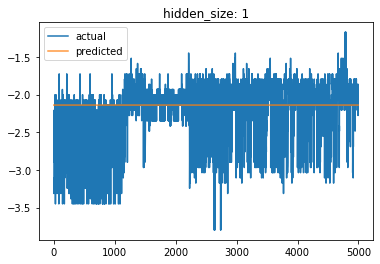

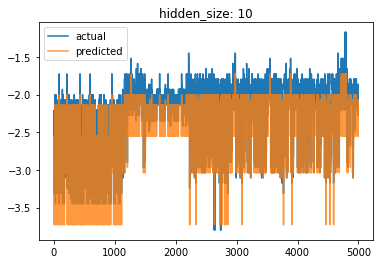

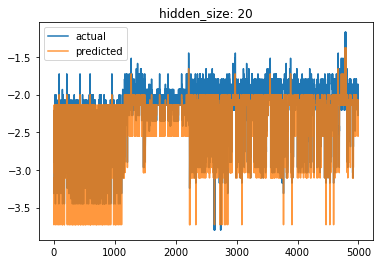

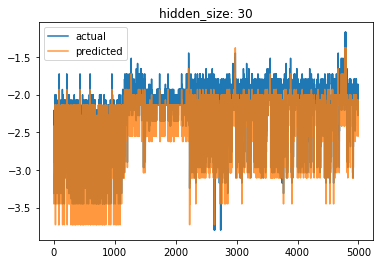

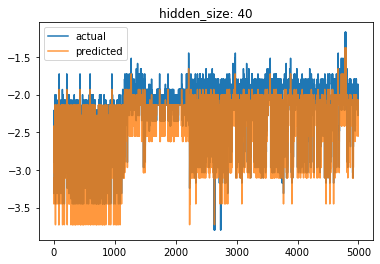

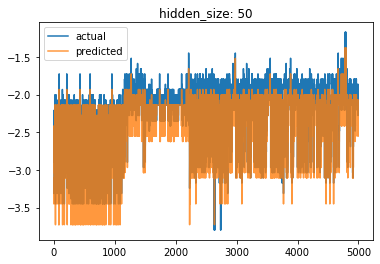

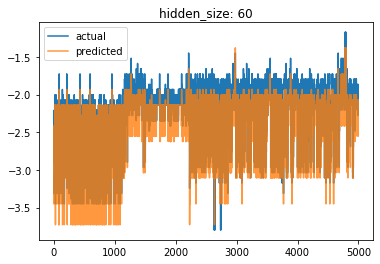

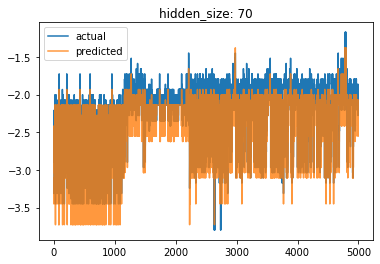

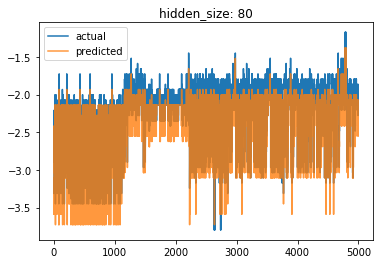

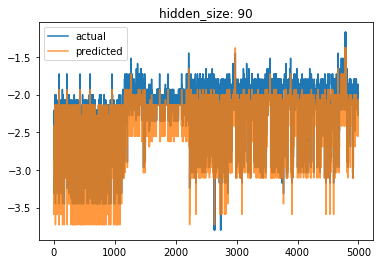

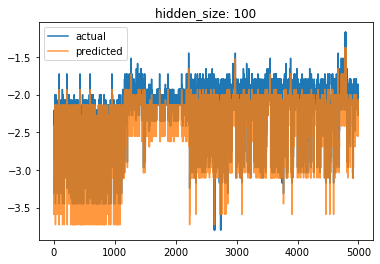

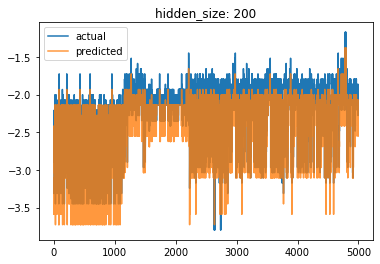

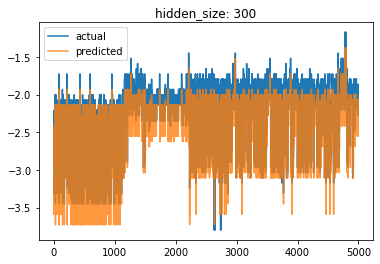

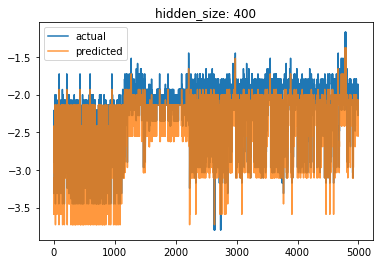

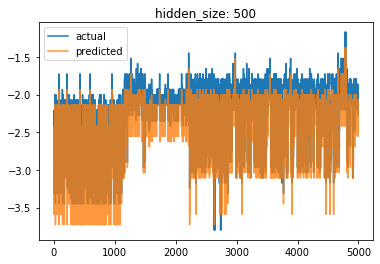

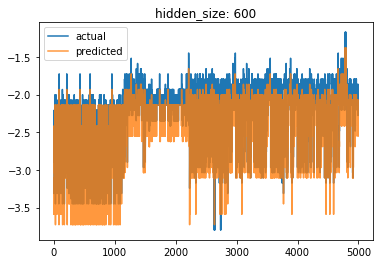

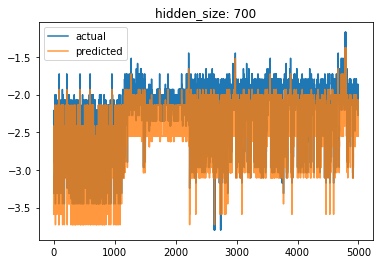

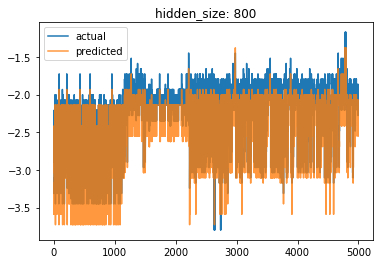

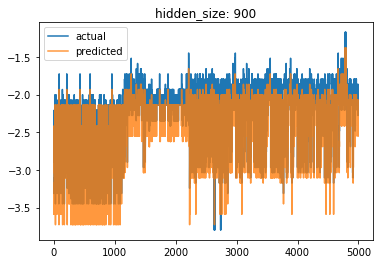

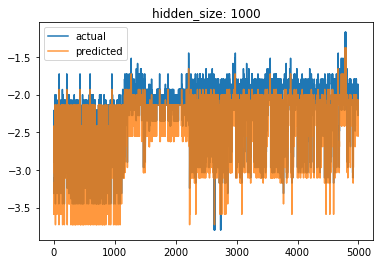

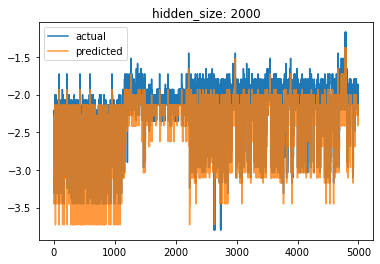

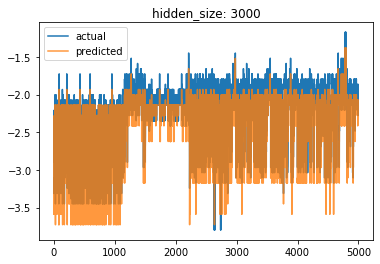

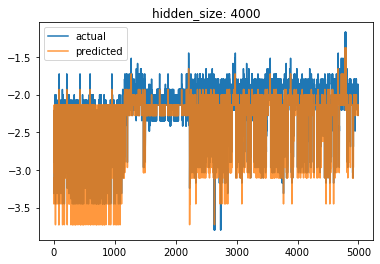

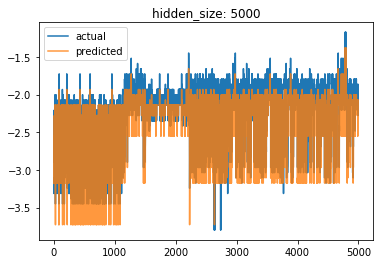

In [12]:
actual = []
predicted = []


for hidden_size in hidden_sizes_lstm:
    data = get_actual_predicted(trace, trace_name, jvm, hidden_size=hidden_size, history_size=40, 
                              output_file_location=lstm_location, seed=1)

    actual = [ val[0] for val in data ]
    predicted = [ val[1] for val in data ]
    
    plt.plot(actual, label="actual")
    plt.plot(predicted, label="predicted", alpha=0.8)
    plt.title("hidden_size: {}".format(hidden_size))
#     plt.xlim((1000, 1020))
    plt.legend()
    plt.show()

In [13]:
hidden_sizes = hidden_sizes_lstm

loss_main["lstm"] = get_loss_dict4(trace, lstm_location, 
                                  hidden_sizes=hidden_sizes, plot_graphs=True)

relevance threshold: 1
hidden_size: 1
hidden_size: 10
Rademacher: 0.004830728159572496, min_rademacher: 0.08250528291392416, min_size: 1
percent improvement: 94.14494685799419
hidden_size: 20
Rademacher: 0.0032365151594439343, min_rademacher: 0.004830728159572496, min_size: 10
percent improvement: 33.00150510372839
hidden_size: 30
Rademacher: 0.0018695906235453475, min_rademacher: 0.0032365151594439343, min_size: 20
percent improvement: 42.23445491704226
hidden_size: 40
Rademacher: 0.0011924293930804055, min_rademacher: 0.0018695906235453475, min_size: 30
percent improvement: 36.21975965951443
hidden_size: 50
Rademacher: 0.001191874418934105, min_rademacher: 0.0011924293930804055, min_size: 40
percent improvement: 0.04654146815912521
hidden_size: 60
Rademacher: 0.0012088216256498524, min_rademacher: 0.001191874418934105, min_size: 50
percent improvement: -1.4218953311292064
hidden_size: 70
Rademacher: 0.001262683266685075, min_rademacher: 0.001191874418934105, min_size: 50
percent impr

In [1]:
rademacher_list_lstm = []
rademacher_window = 5

for hidden_size in hidden_sizes_lstm:
    loss_array = loss_main["lstm"][hidden_size]
    rademacher_list_lstm.append(get_rademacher(loss_array))

NameError: name 'hidden_sizes_lstm' is not defined

# Current

Hidden_size: 1
Rademacher: 0.24586910891360725, alpha: 0.1
Rademacher: 0.1661929330654361, alpha: 0.2
Rademacher: 0.14643145678452715, alpha: 0.30000000000000004
Rademacher: 0.10054093926514711, alpha: 0.4
Rademacher: 0.08298616977535997, alpha: 0.5
Rademacher: 0.058250048624821915, alpha: 0.6
Rademacher: 0.04108490562764166, alpha: 0.7000000000000001
Rademacher: 0.04126289123511752, alpha: 0.8
Rademacher: 0.03090603389535764, alpha: 0.9
Rademacher: 0.025502978232352397, alpha: 1.0
Rademacher: 0.019327676622843307, alpha: 1.1
Rademacher: 0.019251559668414735, alpha: 1.2000000000000002
Rademacher: 0.014077488734391356, alpha: 1.3000000000000003
Rademacher: 0.011163641428163189, alpha: 1.4000000000000001
Rademacher: 0.011166145534688079, alpha: 1.5000000000000002
Rademacher: 0.009512757472560128, alpha: 1.6
Rademacher: 0.009706781775008772, alpha: 1.7000000000000002
Rademacher: 0.0011285561226672943, alpha: 1.8000000000000003
Rademacher: 0.0012019551540115318, alpha: 1.9000000000000001


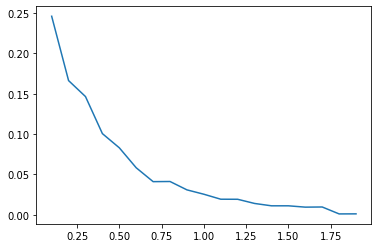

In [12]:
hidden_size = 1
rademacher_list1 = []
print("Hidden_size: {}".format(hidden_size))
for alpha_threshold in np.arange(1e-1, 2, 0.1):
    loss_dict1 = get_loss_dict4(trace, lstm_location, 
                                hidden_sizes=[hidden_size], plot_graphs=True,
                               alpha_threshold=alpha_threshold)
    rademacher_list1.append(get_rademacher(loss_dict1[hidden_size]))
    print("Rademacher: {}, alpha: {}".format(rademacher_list1[-1], alpha_threshold))

plt.plot(np.arange(1e-1, 2, 0.1), rademacher_list1)
plt.show()

Hidden_size: 1
Rademacher: 0.24566631782640075, alpha: 0.1
Rademacher: 0.16697534254365864, alpha: 0.2
Rademacher: 0.14489388125175323, alpha: 0.30000000000000004
Rademacher: 0.10003143302287121, alpha: 0.4
Rademacher: 0.08318418479908492, alpha: 0.5
Rademacher: 0.0582113174113798, alpha: 0.6
Rademacher: 0.04096151695421835, alpha: 0.7000000000000001
Rademacher: 0.0415563171135985, alpha: 0.8
Rademacher: 0.030652590015320932, alpha: 0.9


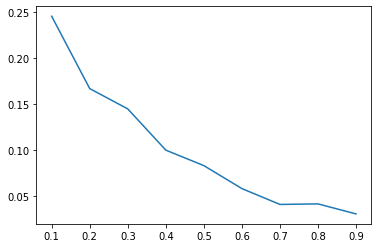

Hidden_size: 10
Rademacher: 0.08074395904057989, alpha: 0.1
Rademacher: 0.021529531470360005, alpha: 0.2
Rademacher: 0.01407556913746908, alpha: 0.30000000000000004
Rademacher: 0.005354208852080227, alpha: 0.4
Rademacher: 0.0049050781549998985, alpha: 0.5
Rademacher: 0.004495094088071156, alpha: 0.6
Rademacher: 0.0040177876669944875, alpha: 0.7000000000000001
Rademacher: 0.003825449601480978, alpha: 0.8
Rademacher: 0.003336429082198514, alpha: 0.9


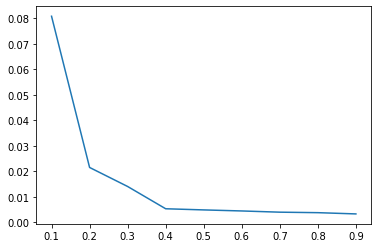

Hidden_size: 20
Rademacher: 0.06246829837928989, alpha: 0.1
Rademacher: 0.025294123854132274, alpha: 0.2
Rademacher: 0.01123680589120207, alpha: 0.30000000000000004
Rademacher: 0.0032458823274328186, alpha: 0.4
Rademacher: 0.0032486908706721713, alpha: 0.5
Rademacher: 0.0017132012747450886, alpha: 0.6
Rademacher: 0.0013054411318544072, alpha: 0.7000000000000001
Rademacher: 0.0012684297642159782, alpha: 0.8
Rademacher: 0.0012559794985418633, alpha: 0.9


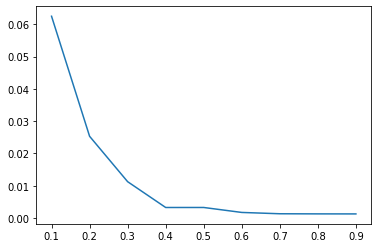

Hidden_size: 30
Rademacher: 0.05066878925645722, alpha: 0.1
Rademacher: 0.03411148484086296, alpha: 0.2
Rademacher: 0.012035925147508472, alpha: 0.30000000000000004
Rademacher: 0.0017531479836090163, alpha: 0.4
Rademacher: 0.0017617778131429915, alpha: 0.5
Rademacher: 0.0012676277379512363, alpha: 0.6
Rademacher: 0.001278159844691195, alpha: 0.7000000000000001
Rademacher: 0.0011927610572905313, alpha: 0.8
Rademacher: 0.0011943448479192036, alpha: 0.9


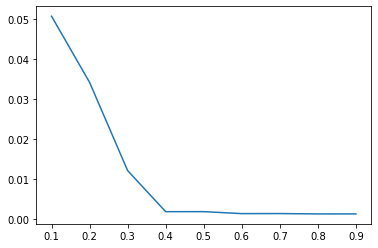

Hidden_size: 40
Rademacher: 0.04567533526176858, alpha: 0.1
Rademacher: 0.034514360054467404, alpha: 0.2
Rademacher: 0.011432554792409792, alpha: 0.30000000000000004
Rademacher: 0.0011790278013987922, alpha: 0.4
Rademacher: 0.0012499152011284829, alpha: 0.5
Rademacher: 0.0012387749357977973, alpha: 0.6
Rademacher: 0.0012454110867881894, alpha: 0.7000000000000001
Rademacher: 0.0012174132774184253, alpha: 0.8
Rademacher: 0.0012335989708191213, alpha: 0.9


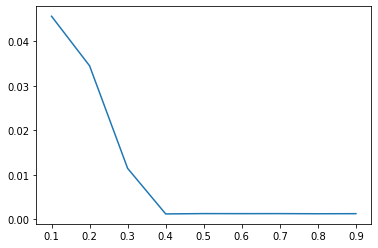

Hidden_size: 50
Rademacher: 0.04606124373561635, alpha: 0.1
Rademacher: 0.03327677946385379, alpha: 0.2
Rademacher: 0.011183464611612057, alpha: 0.30000000000000004
Rademacher: 0.001165366306517977, alpha: 0.4
Rademacher: 0.0011714119618654656, alpha: 0.5
Rademacher: 0.0011398086434623199, alpha: 0.6
Rademacher: 0.0012544564430083077, alpha: 0.7000000000000001
Rademacher: 0.0012264148666216422, alpha: 0.8
Rademacher: 0.0012414462433113587, alpha: 0.9


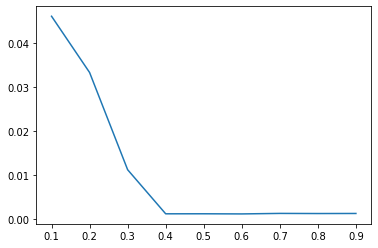

Hidden_size: 60
Rademacher: 0.04942261788009351, alpha: 0.1
Rademacher: 0.034986053903333, alpha: 0.2
Rademacher: 0.011544247308102855, alpha: 0.30000000000000004
Rademacher: 0.0012540530566119035, alpha: 0.4
Rademacher: 0.001202954232118179, alpha: 0.5
Rademacher: 0.0011614628774597347, alpha: 0.6
Rademacher: 0.0011737146696925674, alpha: 0.7000000000000001
Rademacher: 0.0012253482772202327, alpha: 0.8
Rademacher: 0.0011511805920951933, alpha: 0.9


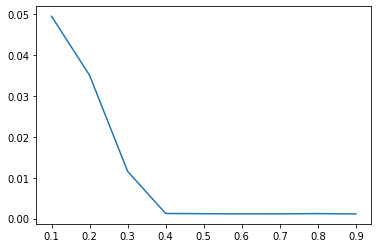

Hidden_size: 70
Rademacher: 0.050797309740628765, alpha: 0.1
Rademacher: 0.03527753991080388, alpha: 0.2
Rademacher: 0.012163312777454159, alpha: 0.30000000000000004
Rademacher: 0.0012149355719889062, alpha: 0.4
Rademacher: 0.0012515864891174606, alpha: 0.5
Rademacher: 0.0012762878598852976, alpha: 0.6
Rademacher: 0.001219532579756696, alpha: 0.7000000000000001
Rademacher: 0.0012424108017914076, alpha: 0.8
Rademacher: 0.0011941582678069627, alpha: 0.9


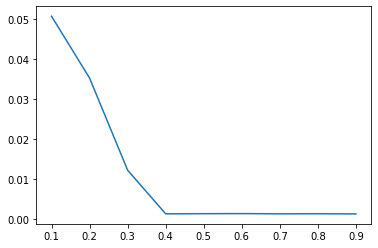

Hidden_size: 80
Rademacher: 0.05074827675894506, alpha: 0.1
Rademacher: 0.03480986192425327, alpha: 0.2
Rademacher: 0.011937325541727278, alpha: 0.30000000000000004
Rademacher: 0.0012831853637452174, alpha: 0.4
Rademacher: 0.001322796405231764, alpha: 0.5
Rademacher: 0.0012139797748321702, alpha: 0.6
Rademacher: 0.0011877874743085877, alpha: 0.7000000000000001
Rademacher: 0.0011926953639318368, alpha: 0.8
Rademacher: 0.0012302688933174637, alpha: 0.9


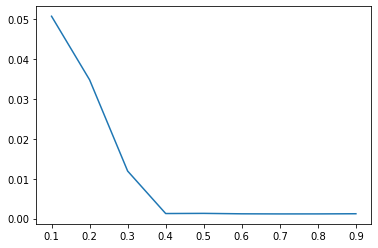

Hidden_size: 90
Rademacher: 0.050864468219275406, alpha: 0.1
Rademacher: 0.034671567246851186, alpha: 0.2
Rademacher: 0.011575168866320406, alpha: 0.30000000000000004
Rademacher: 0.0012108230630039042, alpha: 0.4
Rademacher: 0.0012604259470458295, alpha: 0.5
Rademacher: 0.0012366253954166448, alpha: 0.6
Rademacher: 0.0011880447288549188, alpha: 0.7000000000000001
Rademacher: 0.001234392963487693, alpha: 0.8
Rademacher: 0.0012342564657331536, alpha: 0.9


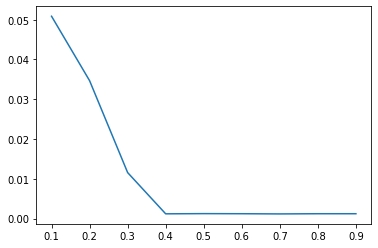

Hidden_size: 100
Rademacher: 0.048647126107269636, alpha: 0.1
Rademacher: 0.032667383806283756, alpha: 0.2
Rademacher: 0.01113940606520101, alpha: 0.30000000000000004
Rademacher: 0.0012187123827236944, alpha: 0.4
Rademacher: 0.0012346948114436529, alpha: 0.5
Rademacher: 0.001231462341663353, alpha: 0.6
Rademacher: 0.0011882240457088398, alpha: 0.7000000000000001
Rademacher: 0.0011772003924686207, alpha: 0.8
Rademacher: 0.001174431570742314, alpha: 0.9


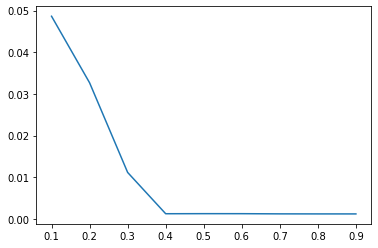

Hidden_size: 200
Rademacher: 0.05484237066704542, alpha: 0.1
Rademacher: 0.03633195758172529, alpha: 0.2
Rademacher: 0.012309388645052422, alpha: 0.30000000000000004
Rademacher: 0.0012459760769863856, alpha: 0.4
Rademacher: 0.0011534838823349313, alpha: 0.5
Rademacher: 0.0011838049023842401, alpha: 0.6
Rademacher: 0.0012199836143601936, alpha: 0.7000000000000001
Rademacher: 0.0012273717043297173, alpha: 0.8
Rademacher: 0.0012013473437649726, alpha: 0.9


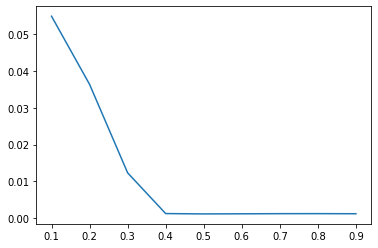

Hidden_size: 300
Rademacher: 0.05889612412828325, alpha: 0.1
Rademacher: 0.0385867680320444, alpha: 0.2
Rademacher: 0.013151338863158432, alpha: 0.30000000000000004
Rademacher: 0.0013022084907113288, alpha: 0.4
Rademacher: 0.0012731674880109157, alpha: 0.5
Rademacher: 0.0013036756547747457, alpha: 0.6
Rademacher: 0.0012139295160452953, alpha: 0.7000000000000001
Rademacher: 0.0012790697521396584, alpha: 0.8
Rademacher: 0.0011974995881222086, alpha: 0.9


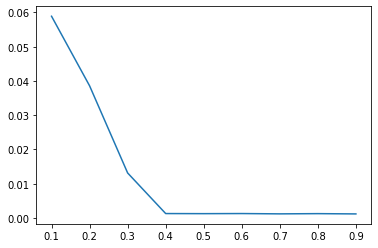

Hidden_size: 400
Rademacher: 0.06241943958251442, alpha: 0.1
Rademacher: 0.038597147356274716, alpha: 0.2
Rademacher: 0.01317966295464941, alpha: 0.30000000000000004
Rademacher: 0.001297230328684973, alpha: 0.4
Rademacher: 0.001334812164628086, alpha: 0.5
Rademacher: 0.0013575751623302974, alpha: 0.6
Rademacher: 0.001262632424930915, alpha: 0.7000000000000001
Rademacher: 0.0012533124989358372, alpha: 0.8
Rademacher: 0.0011869472732512708, alpha: 0.9


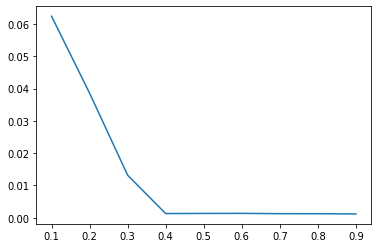

Hidden_size: 500
Rademacher: 0.06279430015511589, alpha: 0.1
Rademacher: 0.03818008177360292, alpha: 0.2
Rademacher: 0.01301671079427464, alpha: 0.30000000000000004
Rademacher: 0.001303463774437551, alpha: 0.4
Rademacher: 0.0012946283031976475, alpha: 0.5
Rademacher: 0.0013199478537607799, alpha: 0.6
Rademacher: 0.0012009315769948977, alpha: 0.7000000000000001
Rademacher: 0.0012639092883112001, alpha: 0.8
Rademacher: 0.001211990759368606, alpha: 0.9


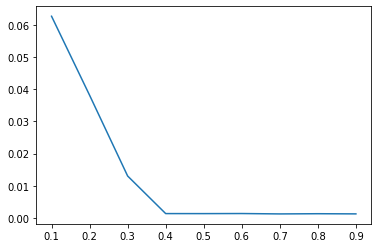

Hidden_size: 600
Rademacher: 0.06273932289195792, alpha: 0.1
Rademacher: 0.03932077480304454, alpha: 0.2
Rademacher: 0.01336930579976513, alpha: 0.30000000000000004
Rademacher: 0.0013115793643180048, alpha: 0.4
Rademacher: 0.001320405431904673, alpha: 0.5
Rademacher: 0.0013276772113339596, alpha: 0.6
Rademacher: 0.001242595822662067, alpha: 0.7000000000000001
Rademacher: 0.0012195386882009598, alpha: 0.8
Rademacher: 0.001255323241224389, alpha: 0.9


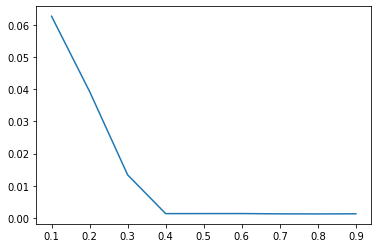

Hidden_size: 700
Rademacher: 0.06454761435294737, alpha: 0.1
Rademacher: 0.03984823516285117, alpha: 0.2
Rademacher: 0.013649470488155008, alpha: 0.30000000000000004
Rademacher: 0.0013561369865038122, alpha: 0.4
Rademacher: 0.0013211595332063041, alpha: 0.5
Rademacher: 0.0013683439296914171, alpha: 0.6
Rademacher: 0.0012610900239794565, alpha: 0.7000000000000001
Rademacher: 0.001260836579649784, alpha: 0.8
Rademacher: 0.0011567305385609815, alpha: 0.9


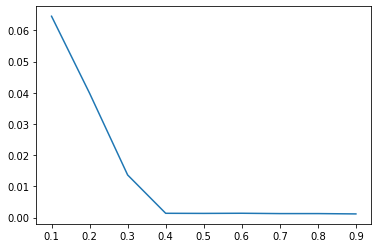

Hidden_size: 800
Rademacher: 0.06554455354372798, alpha: 0.1
Rademacher: 0.03854538119582398, alpha: 0.2
Rademacher: 0.013325965042611238, alpha: 0.30000000000000004
Rademacher: 0.0013137220227676227, alpha: 0.4
Rademacher: 0.0013270163443968952, alpha: 0.5
Rademacher: 0.0013500964015463759, alpha: 0.6
Rademacher: 0.0012775335814530552, alpha: 0.7000000000000001
Rademacher: 0.0012922681394718662, alpha: 0.8
Rademacher: 0.0011759057921277003, alpha: 0.9


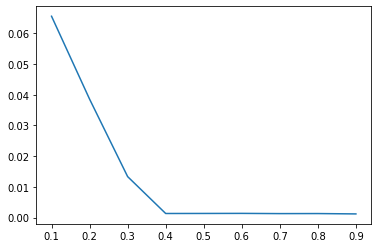

Hidden_size: 900
Rademacher: 0.06818408131613941, alpha: 0.1
Rademacher: 0.040865066963555574, alpha: 0.2
Rademacher: 0.014424095735410496, alpha: 0.30000000000000004
Rademacher: 0.001300693183574902, alpha: 0.4
Rademacher: 0.0013357177119663734, alpha: 0.5
Rademacher: 0.0013425194906732383, alpha: 0.6
Rademacher: 0.0012653514332627224, alpha: 0.7000000000000001
Rademacher: 0.00127827081596533, alpha: 0.8
Rademacher: 0.001213587490792165, alpha: 0.9


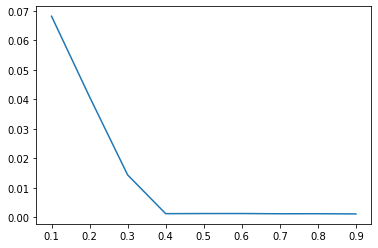

Hidden_size: 1000
Rademacher: 0.07505689203927671, alpha: 0.1
Rademacher: 0.042983284387664154, alpha: 0.2
Rademacher: 0.015195288395847956, alpha: 0.30000000000000004
Rademacher: 0.0013781030230737951, alpha: 0.4
Rademacher: 0.0013566562611925263, alpha: 0.5
Rademacher: 0.001358425038029698, alpha: 0.6
Rademacher: 0.0012184094542476054, alpha: 0.7000000000000001
Rademacher: 0.0012303449630608875, alpha: 0.8
Rademacher: 0.0012539310508073798, alpha: 0.9


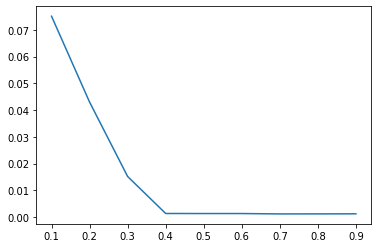

Hidden_size: 2000
Rademacher: 0.07593460457118863, alpha: 0.1
Rademacher: 0.04507566171097162, alpha: 0.2
Rademacher: 0.017731350506221304, alpha: 0.30000000000000004
Rademacher: 0.0013505424847376323, alpha: 0.4
Rademacher: 0.0013348182113625889, alpha: 0.5
Rademacher: 0.0013110634485012154, alpha: 0.6
Rademacher: 0.0013025559061209857, alpha: 0.7000000000000001
Rademacher: 0.0013531940634052741, alpha: 0.8
Rademacher: 0.0011481417545069366, alpha: 0.9


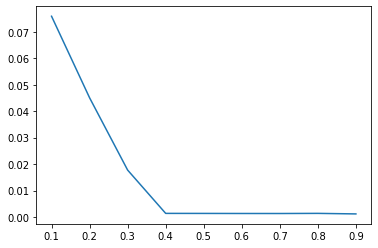

Hidden_size: 3000
Rademacher: 0.08971954095430548, alpha: 0.1
Rademacher: 0.04687360260502799, alpha: 0.2
Rademacher: 0.0182016408657554, alpha: 0.30000000000000004
Rademacher: 0.0013736373005235674, alpha: 0.4
Rademacher: 0.0014163203567700365, alpha: 0.5
Rademacher: 0.0013336686344343138, alpha: 0.6
Rademacher: 0.0012126671099206693, alpha: 0.7000000000000001
Rademacher: 0.0012768719009662165, alpha: 0.8
Rademacher: 0.001187040103932013, alpha: 0.9


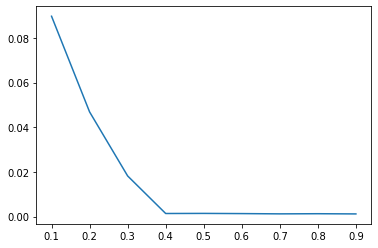

Hidden_size: 4000
Rademacher: 0.0912936322221792, alpha: 0.1
Rademacher: 0.04477817622126936, alpha: 0.2
Rademacher: 0.022050392811127063, alpha: 0.30000000000000004
Rademacher: 0.011563103650871884, alpha: 0.4
Rademacher: 0.007961011696442212, alpha: 0.5
Rademacher: 0.006043545230593871, alpha: 0.6
Rademacher: 0.006088812611203629, alpha: 0.7000000000000001
Rademacher: 0.006355685936338648, alpha: 0.8
Rademacher: 0.005960884462059733, alpha: 0.9


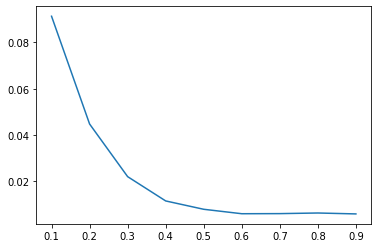

Hidden_size: 5000
Rademacher: 0.11631479774165715, alpha: 0.1
Rademacher: 0.060374195642748374, alpha: 0.2
Rademacher: 0.030228140863597104, alpha: 0.30000000000000004
Rademacher: 0.01625570898962069, alpha: 0.4
Rademacher: 0.016067813816395632, alpha: 0.5
Rademacher: 0.015567949638481834, alpha: 0.6
Rademacher: 0.015089160976605847, alpha: 0.7000000000000001
Rademacher: 0.01526779014502063, alpha: 0.8
Rademacher: 0.015659746445102755, alpha: 0.9


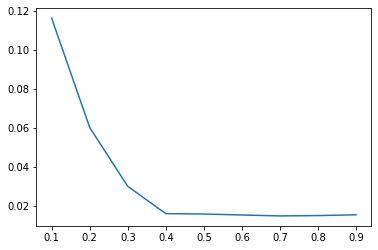

In [24]:
hidden_size = 20
for hidden_size in hidden_sizes:
    rademacher_list1 = []
    print("Hidden_size: {}".format(hidden_size))
    for alpha_threshold in np.arange(1e-1, 1, 0.1):
        loss_dict1 = get_loss_dict4(trace, lstm_location, 
                                    hidden_sizes=[hidden_size], plot_graphs=True,
                                   alpha_threshold=alpha_threshold)
        rademacher_list1.append(get_rademacher(loss_dict1[hidden_size]))
        print("Rademacher: {}, alpha: {}".format(rademacher_list1[-1], alpha_threshold))

    plt.plot(np.arange(1e-1, 1, 0.1), rademacher_list1)
    plt.show()

In [ ]:
for alpha_threshold in np.arange(1e-1, 1, 0.1):
    loss_dict1 = get_loss_dict4(trace, lstm_location, 
                                hidden_sizes=[hidden_size], plot_graphs=True,
                               alpha_threshold=alpha_threshold)
    rademacher_list1.append(get_rademacher(loss_dict1[hidden_size]))
    print("Rademacher: {}, alpha: {}".format(rademacher_list1[-1], alpha_threshold))

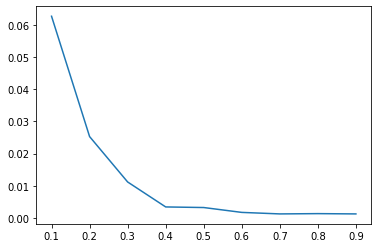

In [20]:
plt.plot(np.arange(1e-1, 1, 0.1), rademacher_list1)
plt.show()

In [187]:
# compute number of parameters
fcn_param_list = []
lstm_param_list = []

for idx, hidden_size in enumerate(hidden_sizes):
    fcn_param_list.append(compute_parameters.get_count(4000, 100, [ hidden_sizes_fcn[idx] ], [ 'fcn' ]))

for idx, hidden_size in enumerate(hidden_sizes):
    lstm_param_list.append(compute_parameters.get_count(100, 100, [100, hidden_sizes_lstm[idx]], ["lstm", "fcn"]))

36230


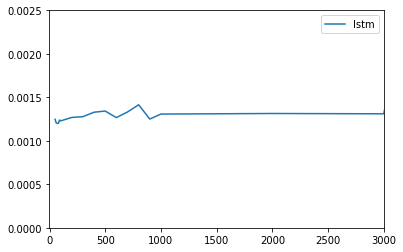

In [241]:
# plt.plot(fcn_param_list, rademacher_list_fcn, label="fcn")
# plt.plot(hidden_sizes_lstm, rademacher_list_lstm, label="lstm")
plt.plot(hidden_sizes_lstm[5:], rademacher_list_lstm[5:], label="lstm")
plt.legend()
plt.ylim((0, 0.0025))
plt.xlim((-5, 3000))
print(compute_parameters.get_count(100, 100, [ 100, 30 ], ["lstm", "fcn"]))
plt.show()

In [238]:
min_rademacher = 1
min_idx = -1
for idx, rademacher_val in enumerate(rademacher_list_lstm):
    if rademacher_val < min_rademacher and (min_rademacher - rademacher_val)/min_rademacher > 0.02:
        min_rademacher = rademacher_val
        min_idx = idx

print("Minimum rademacher: {}, minimum parameters: {}, min_hidden: {}".format(min_rademacher, 
                                                                              lstm_param_list[min_idx], 
                                                                              hidden_sizes_lstm[min_idx]))

Minimum rademacher: 0.0011893068456402989, minimum parameters: 38240, min_hidden: 40


In [ ]:
# plt.plot(fcn_param_list, rademacher_list_fcn, label="fcn")
plt.plot(hidden_sizes_lstm, rademacher_list_lstm, label="lstm")
plt.legend()
# plt.ylim((0.8, 1.1))
plt.xlim((-100, 2500))
plt.show()

In [ ]:
# plt.plot(fcn_param_list, rademacher_list_fcn, label="fcn")
plt.plot(hidden_sizes_lstm, rademacher_list_lstm, label="lstm")

plt.legend()
plt.ylim((0.1, 0.15))
plt.xlim((-100, 500))
plt.show()

for idx, val in enumerate(rademacher_list_lstm):
    print(hidden_sizes_lstm[idx]," ", val)

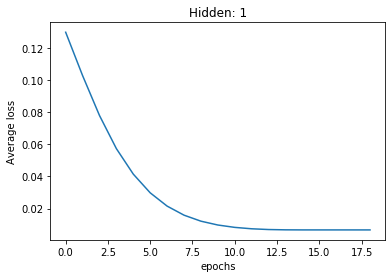

min: 0.006753925763443113
converged
4.218555986913036e-08


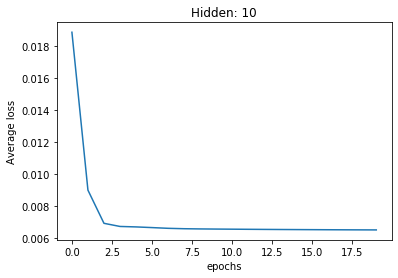

min: 0.006515979130566119
converged
3.338038548828491e-06


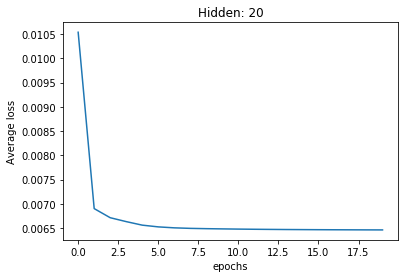

min: 0.006460084822028875
converged
8.276347070934262e-07


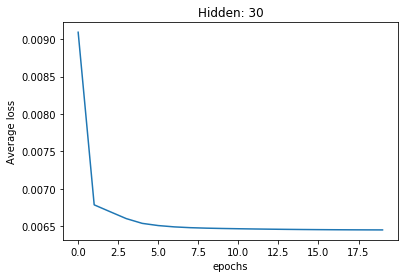

min: 0.00644974686987698
converged
5.801096558582033e-07


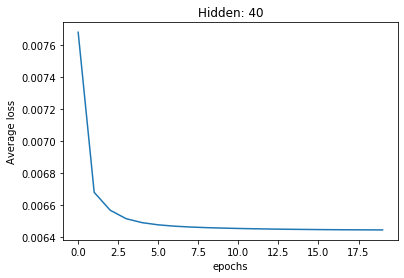

min: 0.006443954028189182
converged
2.8845258057130785e-07


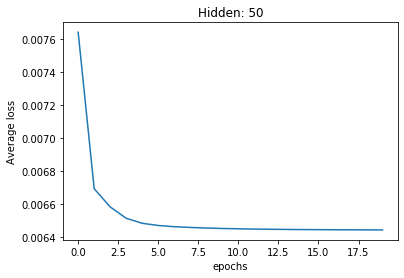

min: 0.00644139517210424
converged
2.7816817164353497e-07


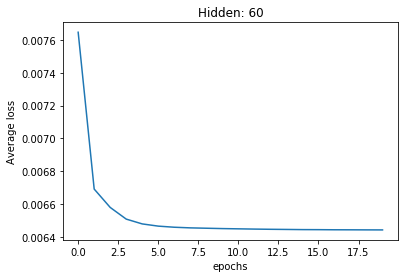

min: 0.006442096430435778
converged
2.846460789435179e-07


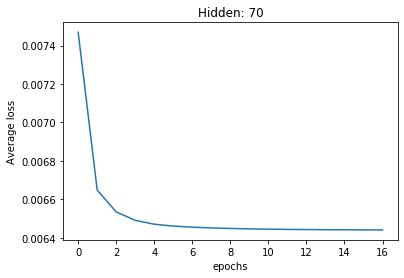

min: 0.006441320435330272
converged
7.620304822916757e-08


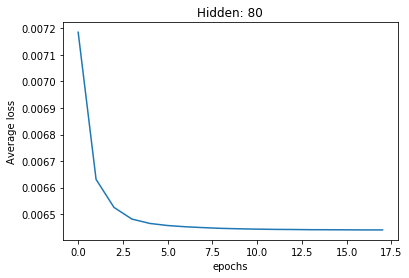

min: 0.006440849979221821
not converged
-3.2320618638045917e-09


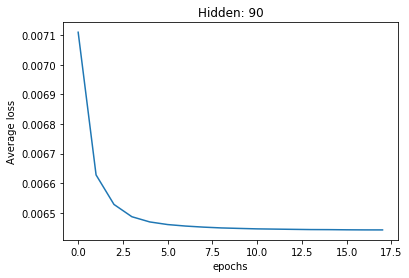

min: 0.0064419065177440645
converged
7.980652153537215e-08


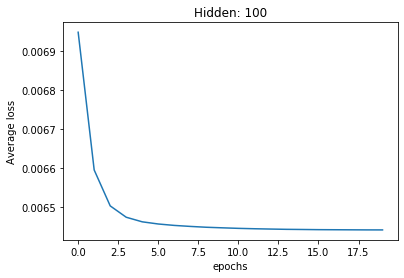

min: 0.006441159141436219
converged
6.330311298503172e-08


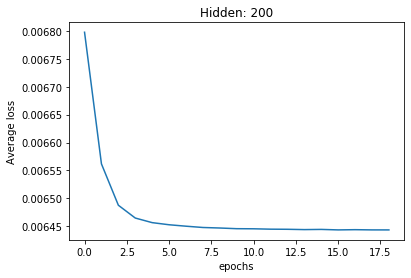

min: 0.0064431527655571695
converged
4.197396338053577e-08


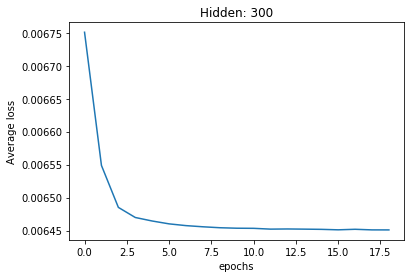

min: 0.006450978713482618
converged
4.4376403092981354e-08


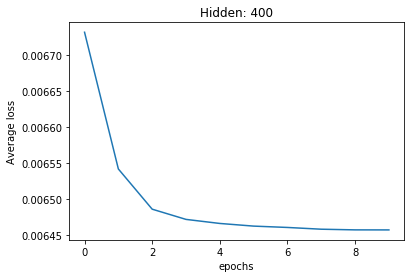

min: 0.006456933614611626
converged
6.205141544254195e-08


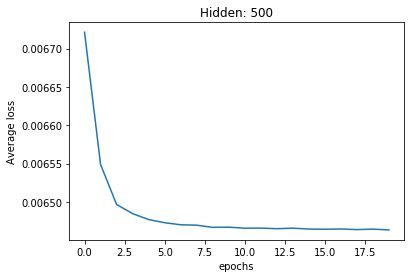

min: 0.006463514940068126
converged
1.002980768681494e-06


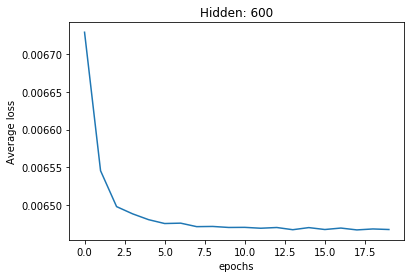

min: 0.006467536263912916
converged
7.302056998018114e-07


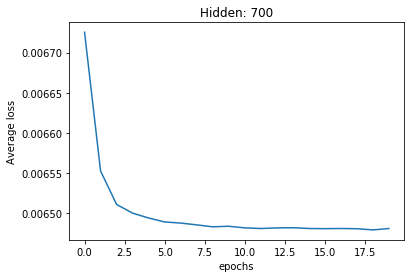

min: 0.006479025955870747
not converged
-1.7599433660506897e-06


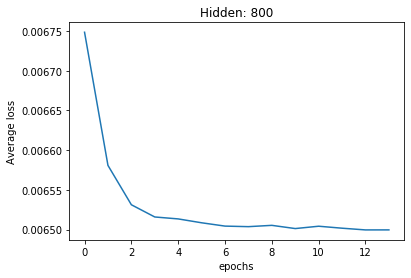

min: 0.006499561455100775
not converged
-3.284290433017145e-08


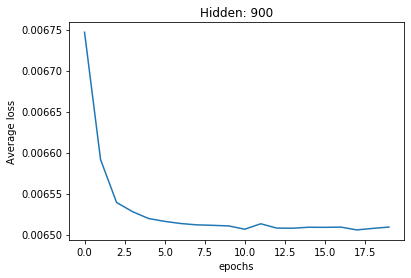

min: 0.006505660152062775
not converged
-1.590770483017763e-06


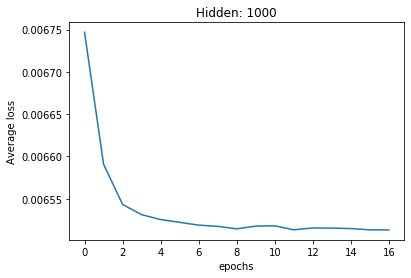

min: 0.006513104669377208
converged
9.244233369846283e-08


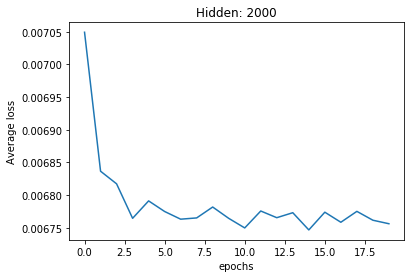

min: 0.006746683833003044
converged
5.387661606072805e-06


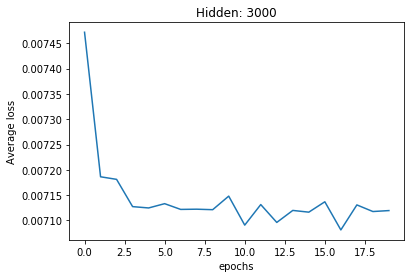

min: 0.007081378372013569
not converged
-1.8735803663742084e-06


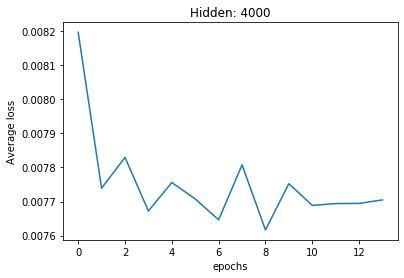

min: 0.007616647761687636
not converged
-1.0342617332934761e-05


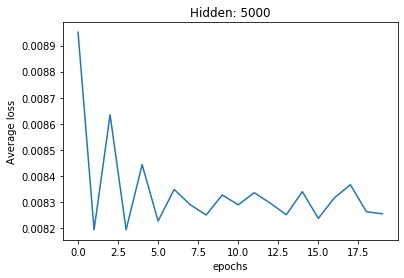

min: 0.008193571276217698
converged
7.95521996915273e-06


In [180]:
loss_list = []

for hidden_size in hidden_sizes_lstm:
    epochTrace = np.load('{}/{}/{}/epochTrace_{}_{}_{}_{}.npy'.format(lstm_location, 
                                                                      trace_name, 
                                                                      jvm, 40, 0, 
                                                                      hidden_size, 1))
    plt.title("Hidden: {}".format(hidden_size))
    plt.plot(epochTrace)
    plt.xlabel("epochs")
    plt.ylabel("Average loss")
    plt.show()
    
    print("min: {}".format(np.min(epochTrace)))
    
    if abs(epochTrace[-2] - epochTrace[-1]) < 6e-5 and epochTrace[-2] - epochTrace[-1] >= 0:
        print("converged")
        print(epochTrace[-2] - epochTrace[-1])
    else:
        print("not converged")
        print(epochTrace[-2] - epochTrace[-1])

## FCN

In [147]:
hidden_sizes = hidden_sizes_fcn

loss_main["fcn"] = get_loss_dict3(trace, fcn_location, 
                                 hidden_sizes=hidden_sizes, plot_graphs=True)

relevance threshold: 1
hidden_size: 1
hidden_size: 10
Rademacher: 0.5730584467574059, min_rademacher: 1.0, min_size: 1
percent improvement: 42.694155324259405
hidden_size: 20
Rademacher: 0.9437550040032027, min_rademacher: 0.5730584467574059, min_size: 10
percent improvement: -64.68739084876006
hidden_size: 30
Rademacher: 0.8993194555644518, min_rademacher: 0.5730584467574059, min_size: 10
percent improvement: -56.93328676213767
hidden_size: 40
Rademacher: 0.3530824659727782, min_rademacher: 0.5730584467574059, min_size: 10
percent improvement: 38.38630806845966
hidden_size: 50
Rademacher: 0.48178542834267385, min_rademacher: 0.3530824659727782, min_size: 40
percent improvement: -36.451247165532806
hidden_size: 60
Rademacher: 0.2864291433146517, min_rademacher: 0.3530824659727782, min_size: 40
percent improvement: 18.877551020408166
hidden_size: 70
Rademacher: 0.4567654123298637, min_rademacher: 0.2864291433146517, min_size: 60
percent improvement: -59.46890286512922
hidden_size: 80
Ra

In [ ]:
actual = []
predicted = []

for hidden_size in hidden_sizes_fcn:
    data = get_actual_predicted(trace, trace_name, jvm, hidden_size=hidden_size, history_size=40, 
                            output_file_location=fcn_location)

    actual = [ val[0] for val in data ]
    predicted = [ val[1] for val in data ]
    
    plt.plot(actual, label="actual")
    plt.plot(predicted, label="predicted", alpha=0.8)
    plt.title("hidden_size: {}".format(hidden_size))
#     plt.xlim((1000, 1020))
    plt.legend()
    plt.show()

In [148]:
rademacher_list_fcn = []

for hidden_size in hidden_sizes_fcn:
    loss_array = loss_main["fcn"][hidden_size]
    rademacher_list_fcn.append(get_rademacher(loss_array))

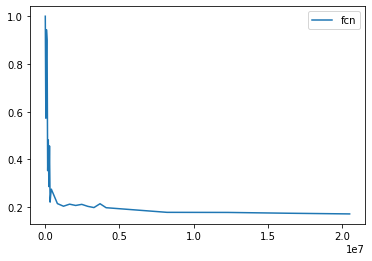

In [150]:
plt.plot(fcn_param_list, rademacher_list_fcn, label="fcn")
# plt.plot(lstm_param_list, rademacher_list_lstm, label="lstm")
# plt.xlim((0, 2e5))
plt.legend()

In [ ]:
loss_list = []

for hidden_size in hidden_sizes_fcn:
    epochTrace = np.load('{}/{}/{}/epochTrace_{}_{}_{}_{}.npy'.format(
                                                fcn_location, 
                                                                  trace_name, jvm, 40, 
                                                       1, hidden_size, 1))
        
    plt.title("Hidden: {}".format(hidden_size))
    plt.plot(epochTrace)
    plt.show()
    
    if epochTrace[-2] - epochTrace[-1] < 1e-3:
        print("converged")

In [ ]:
actual = []
predicted = []


for hidden_size in hidden_sizes_fcn:
    data = get_actual_predicted(trace, trace_name, jvm, hidden_size=hidden_sizes_fcn[2], history_size=40, 
                              model_type="fcn", 
                                output_file_location="/media/arjun/Shared/chaos/output_files_v2/fcn")

    actual = [ val[0] for val in data ]
    predicted = [ val[1] for val in data ]
    
    plt.plot(actual, label="actual")
    plt.plot(predicted, label="predicted", alpha=0.8)
    plt.title("hidden_size: {}".format(hidden_size))
#     plt.xlim((1000, 1020))
    plt.legend()
    plt.show()